# Counting Operations of Efficientnet-b0
How many operations are carried out by the network, broken down by layer.

In [1]:
%%capture
import tensorflow as tf
import pprint
import matplotlib.pyplot as plt
import numpy as np
import efficientnet.efficientnet_builder as net_builder
import util

# tf.logging.set_verbosity(tf.logging.WARN)
tf.logging.set_verbosity(tf.logging.ERROR)
# Set locale for printing (e.g. where to place integer separator ','s).
import locale
locale.setlocale(locale.LC_ALL, '')  # Use '' for auto, or force e.g. to 'en_US.UTF-8'

## Calculation using Tensorflow profiler 

In [2]:
# https://medium.com/@shinseung428/freezing-and-calculating-flops-in-tensorflow-9df5176bb7ee
with tf.Session() as sess, tf.Graph().as_default() as g:
    image_inputs = tf.keras.layers.Input(shape=( 112, 112, 3), batch_size=1, dtype=tf.float32)
    logits, _ = net_builder.build_model(image_inputs,  model_name='efficientnet-b0',  training=False)
    probs = tf.nn.softmax(logits)
    # run_meta = tf.RunMetadata()
    config_dict = tf.profiler.ProfileOptionBuilder(tf.profiler.ProfileOptionBuilder.float_operation())
    #ops = config_dict.with_node_names(hide_name_regexes=['.*/Initializer/.*', '.*/tpu_batch_normalization.*']) \
    ops = config_dict.account_displayed_op_only(True).build()
    ans = tf.profiler.profile(g,  options=ops, cmd='op')
    # print(ans)

230,379,149


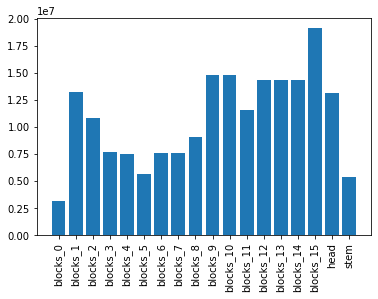

In [3]:
# dir(ans)
import re
print(f'{ans.total_float_ops:n}')

nodes_to_ops = {}
blocks_to_ops = {}
for n in ans.children[0].graph_nodes:
    prefix = 'efficientnet-b0/model/'
    name = n.name[len(prefix):]
    nodes_to_ops[name] = n.float_ops
    block = name.split('/')[0]
    blocks_to_ops[block] = blocks_to_ops.get(block, 0) + n.float_ops
        
def natural_key(string_):
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

sorted_block_counts = sorted([(k,v) for k,v in blocks_to_ops.items()], 
                             key=lambda x: natural_key(x[0]))
plt.bar(range(len(sorted_block_counts)), [i[1] for i in sorted_block_counts], align='center')
plt.xticks(range(len(blocks_to_ops)), [i[0] for i in sorted_block_counts], rotation='vertical')
plt.show()
        
        

In [4]:
import micronet.models.mobilenetv2 as mobilenet
run_metadata = tf.RunMetadata()
with tf.Session() as sess, tf.Graph().as_default() as g:
    image_inputs = tf.keras.layers.Input(shape=(224,224,3), batch_size=1)
    m = mobilenet.create_model(input_shape=(224, 224, 3))
    m(image_inputs, training=False)
    config_dict = tf.profiler.ProfileOptionBuilder(tf.profiler.ProfileOptionBuilder.float_operation())
    ops = config_dict.account_displayed_op_only(True)\
                     .select(['float_ops', 'op_types']).order_by('name').build()
    ans = tf.profiler.profile(g,  options=ops, cmd='op', run_meta=run_metadata)    

In [5]:
print(f'{ans.total_float_ops:n}')
# ans

608,625,165
